In [1]:
import sys; sys.path.append('/home/cb2714/wwa/'); from wwa import *
rnm = "socal-baja"

# import rioxarray as rxr

In [2]:
xn, xx, yn, yx = [-125,-110,30,40]
sf = gpd.read_file("sf_socal-baja").to_crs(epsg = 4326)


fpath = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/cali-wildfires/"

---
# CDS download requests

In [1]:
import os, cdsapi
from IPython.display import clear_output

client = cdsapi.Client()

2025-01-13 08:46:52,726 WARNING [2025-01-08T00:00:00] Please be informed that Beta URL (cds-beta) have been now discontinued. If you still need to migrate, please follow [available instructions here](https://forum.ecmwf.int/t/goodbye-legacy-climate-data-store-hello-new-climate-data-store-cds/6380)
2025-01-13 08:46:52,727 INFO [2024-09-28T00:00:00] **Welcome to the New Climate Data Store (CDS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new CDS for the benefit of everyone. Thank you.
2025-01-13 08:46:52,728 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-01-13 08:46:52,728 INFO [2024-09-16T00:00:00] Remember that you need to have an ECMWF account to use the new CDS. **Your old CDS c

## Noon FWI variables - ERA5

In [3]:
for y in range(2024,1949,-1):
        
        y = str(y)
        
        new_fnm = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/cali-wildfires/era5/era5_noon-vars_"+y+".nc"
        print(y)
        if os.path.exists(new_fnm): continue
                
        dataset = "reanalysis-era5-single-levels"
        request = {
            "product_type": ["reanalysis"],
            "variable": [
                "10m_u_component_of_wind",
                "10m_v_component_of_wind",
                "2m_dewpoint_temperature",
                "2m_temperature"
            ],
            "year": [y],
            "month": [
                "01", "02", "03",
                "04", "05", "06",
                "07", "08", "09",
                "10", "11", "12"
            ],
            "day": [
                "01", "02", "03",
                "04", "05", "06",
                "07", "08", "09",
                "10", "11", "12",
                "13", "14", "15",
                "16", "17", "18",
                "19", "20", "21",
                "22", "23", "24",
                "25", "26", "27",
                "28", "29", "30",
                "31"
            ],
            "time": ["20:00"],
            "data_format": "netcdf",
            "download_format": "unarchived",
            "area": [40, -125, 30, -110]
        }

        client.retrieve(dataset, request, new_fnm)
        
clear_output(wait = False)
print("Done.")

Done.


## 24h accumulated precip - ERA5

In [ ]:
for y in range(2023,1950,-1):
        
        y = str(y)
        
        new_fnm = "/rds/general/user/cb2714/projects/wwa/ephemeral/cali-wildfires/era5/era5_pr24h_"+y+".nc"
        print(y)
        if os.path.exists(new_fnm): continue
        
        dataset = "derived-era5-single-levels-daily-statistics"
        request = {
            "product_type": "reanalysis",
            "variable": ["total_precipitation"],
            "year": y,
            "month": [
                "01", "02", "03",
                "04", "05", "06",
                "07", "08", "09",
                "10", "11", "12"
            ],
            "day": [
                "01", "02", "03",
                "04", "05", "06",
                "07", "08", "09",
                "10", "11", "12",
                "13", "14", "15",
                "16", "17", "18",
                "19", "20", "21",
                "22", "23", "24",
                "25", "26", "27",
                "28", "29", "30",
                "31"
            ],
            "daily_statistic": "daily_sum",
            "time_zone": "utc-08:00",
            "frequency": "1_hourly",
            "area": [40, -125, 30, -110],
            'format': 'netcdf'
        }

        client.retrieve(dataset, request, new_fnm)
        clear_output(wait = False)
        
print("Done.")

## Hourly VPD variables - ERA5Land

In [ ]:
for y in range(1980,1949,-1):
    for m in range(1,13):

        y = str(y)
        m = str(m).rjust(2,"0")
        new_fnm = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/cali-wildfires/era5land/era5land_vpd-vars_"+y+"-"+m+".nc"
        print(y+m)
        if os.path.exists(new_fnm): continue

        dataset = "reanalysis-era5-land"
        request = {
        "variable": [
            "2m_dewpoint_temperature",
            "2m_temperature",
            "10m_u_component_of_wind",
            "10m_v_component_of_wind"
        ],
        "year": y,
        "month": m,
        "day": [
            "01", "02", "03",
            "04", "05", "06",
            "07", "08", "09",
            "10", "11", "12",
            "13", "14", "15",
            "16", "17", "18",
            "19", "20", "21",
            "22", "23", "24",
            "25", "26", "27",
            "28", "29", "30",
            "31"
        ],
        "time": [
            "00:00", "01:00", "02:00",
            "03:00", "04:00", "05:00",
            "06:00", "07:00", "08:00",
            "09:00", "10:00", "11:00",
            "12:00", "13:00", "14:00",
            "15:00", "16:00", "17:00",
            "18:00", "19:00", "20:00",
            "21:00", "22:00", "23:00"
        ],
        "data_format": "netcdf",
        "download_format": "unarchived",
        "area": [40, -125, 30, -110]
        }
        client.retrieve(dataset, request, new_fnm)
        clear_output(wait = False)

print("Done.")

196801


2025-01-13 11:01:11,581 INFO [2025-01-09T00:00:00] Please be aware that ERA5 data from 1st January 2025 was degraded and is being corrected. Watch the [Forum announcement](https://forum.ecmwf.int/t/era5-data-from-1st-january-2025-was-degraded-and-is-being-corrected/10689) for updates.
2025-01-13 11:01:11,582 INFO Request ID is d64941a3-fc47-4b47-b868-4e512e08db07
2025-01-13 11:01:11,633 INFO status has been updated to accepted
2025-01-13 11:03:05,725 INFO status has been updated to running


---
# MSWX FWI

## Extract FWI variables

In [74]:
fpath = "/rds/general/user/cb2714/home/00_WWA_project_folder/live/data/mswx/"
outpath = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/cali-wildfires/mswx/"

In [21]:
for y in range(2024, 2026):
    print(y, end = " ")
    
    for varnm in ["P", "RelHum", "Tmax", "Wind"]:
        
        new_fnm = outpath+varnm+"_"+str(y)+".nc"
        if os.path.exists(new_fnm): continue
            
        print(varnm, end = " ")
        
        da = wrap_lon(xr.open_mfdataset(fpath+varnm+"/"+str(y)+"/*.nc")).sel(lon = slice(xn,xx), lat = slice(yn,yx))
        da.to_netcdf(new_fnm)
    print("")

2024 
2025 P RelHum Tmax Wind 


## Compute FWI

In [75]:
from xclim.indicators.atmos import cffwis_indices

# compile all the variables
# ds = xr.merge([xr.open_mfdataset([fnm for fnm in glob.glob(outpath+"*"+varnm+"*.nc") if fnm[-7:-3] >= "2024"]) for varnm in ["P", "RelHum", "Tmax", "Wind"]]).load()  # 2024-25 only
ds = xr.merge([xr.open_mfdataset(outpath+"*"+varnm+"*.nc") for varnm in ["P", "RelHum", "Tmax", "Wind"]]).load()
ds = ds.rename(precipitation = "pr", relative_humidity = "hurs", air_temperature = "tas", wind_speed = "sfcWind")

# mask to land surface only
ds = ds.where(regionmask.defined_regions.natural_earth_v5_0_0.land_50.mask(ds) == 0)

fwi = cffwis_indices(ds = ds, overwintering = False)
fwi = xr.merge(fwi)

fwi.to_netcdf(outpath+"fwi_mswx_1979-2025.nc")

## Daily time series

In [103]:
da = fwi.rio.write_crs(sf.crs).rename(lat = "y", lon = "x")
da_ts = da.rio.clip(sf.geometry.values, all_touched = True).mean(["x", "y"]).reset_coords(drop = True)
for varnm in list(da_ts.data_vars): da_ts[varnm].to_netcdf("data/mswx_"+varnm+"_"+rnm+".nc")

# Compile VPD variables

In [ ]:
fpath = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/cali-wildfires/"

In [13]:
fl = sorted(glob.glob(fpath+"era5land/era5land_vpd-vars_*.nc"))
fl = [fnm for fnm in fl if int(fnm[-10:-6]) >= 1970]

In [14]:
ds = wrap_lon(xr.open_mfdataset(fl))
ds = ds.reset_coords(drop = True).rename(valid_time = "time")

In [16]:
d2m = convert_units_to(ds.d2m, "degC").load()
t2m = convert_units_to(ds.t2m, "degC").load()
        
vpd = np.exp(17.25*t2m / (243.04 + t2m)) - np.exp(17.25*d2m / (243.04 + d2m))
vpd_max = vpd.resample(time = "D").max().rename("vpd")

tas_max = t2m.resample(time = "D").max()

wspd = (np.sqrt(ds.u10**2 + ds.v10**2)).rename("sfcWind")
wspd_max = wspd.resample(time = "D").max()

In [17]:
vpd_max.to_netcdf(fpath+"era5-land_vpdmax_197001-198012.nc")
tas_max.to_netcdf(fpath+"era5-land_tasmax_197001-198012.nc")
wspd_max.to_netcdf(fpath+"era5-land_sfcWindmax_197001-198012.nc")

/rds/general/user/cb2714/home/anaconda3/envs/wwa/lib/python3.10/site-packages/dask/array/reductions.py:640: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


---
# Get time series - obs

## Nino indices

### Detrended Nino3.4

Use monthly mean SST from 20S:20N to detrend [Nino3.4](https://climexp.knmi.nl/getindices.cgi?WMO=NCDCData/ersst_nino3.4a&STATION=NINO3.4&TYPE=i&id=someone@somewhere)

In [92]:
# download latest SST data from ERSST
! wget https://downloads.psl.noaa.gov/Datasets/noaa.ersst.v5/sst.mnmean.nc
clear_output(wait = False)

In [2]:
ersst = wrap_lon(xr.open_dataset("sst.mnmean.nc").sst)

# quick method for area-weighted averaging (will add to WWA main but need to generalise dims first)
def awmean(da): return da.weighted(np.cos(np.deg2rad(da.lat))).mean(["lat", "lon"])

In [123]:
nino34 = awmean(ersst.sel(lat = slice(-5,5), lon = slice(-170,-120)))
sst_tropical = awmean(ersst.sel(lat = slice(-20,20)))

nino34_det = (nino34 - sst_tropical).rename("nino34")
nino34_det.to_netcdf("data/ersst_nino34_detrended.nc")

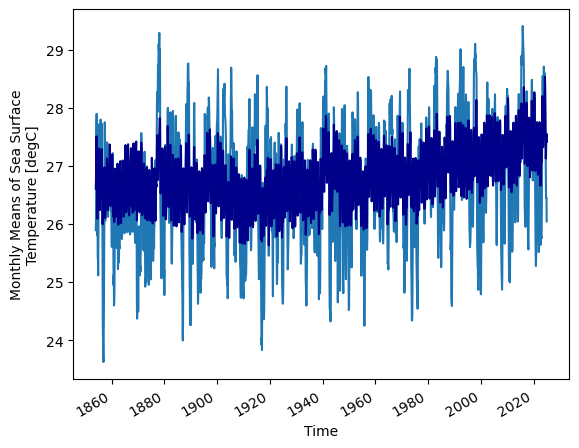

In [116]:
nino34.plot()
sst_tropical.plot(color = "darkblue")

### Nino modoki

$EMI = SST_{C} - 0.5SST_E - 0.5SST_W$

where
$SST_C$ is the SST anomaly from 10S-10N, 165W-140W; $SST_E$ is the SST anomaly from 10S-20N, 125E-145E; and $SST_W$ is the SST anomaly from 15S-5N, 110W-70W.


In [11]:
sst_c = ersst.sel(lat = slice(-10,10), lon = slice(-145,165))
sst_e = ersst.sel(lat = slice(-10,20), lon = slice(125,145))
sst_w = ersst.sel(lat = slice(-15,5), lon = slice(-110,-70))

In [12]:
sst_c_ts = sst_c.mean(["lat", "lon"])
sst_e_ts = sst_e.mean(["lat", "lon"])
sst_w_ts = sst_w.mean(["lat", "lon"])

In [ ]:
emi = sst_c_ts - (0.5 * sst_e_ts) - (0.5 * sst_w_ts)
emi.to_dataframe().to_csv("data/nino-modoki.csv")

# OND indices

In [16]:
nino34 = xr.open_dataset("data/ersst_nino34_detrended.nc").nino34

nino34_ond = nino34.rolling(time = 3).mean().groupby("time.month")[12]
nino34_ond.assign_coords(time = nino34_ond.time.dt.year).rename("nino34_ond", time = "year").to_dataframe().to_csv("ts/nino34_ond.csv")

nino34_nd = nino34.rolling(time = 2).mean().groupby("time.month")[12]
nino34_nd.assign_coords(time = nino34_nd.time.dt.year).rename("nino34_nd", time = "year").to_dataframe().to_csv("ts/nino34_nd.csv")

---
# Extract region from rotated-pole data

In [30]:
import rioxarray as rxr

nam44 = xr.open_dataset("sftlf_NAM-44_ICHEC-EC-EARTH_historical_r0i0p0_SMHI-RCA4_v1_fx.nc").sftlf

# trim data down to larger region of interest
box = np.logical_and(np.logical_and(nam44.lon >= xn, nam44.lon <= xx), np.logical_and(nam44.lat >= yn, nam44.lat <= yx))
box = box.where(box == 1).dropna("rlon", "all").dropna("rlat", "all")
nam44 = nam44.sel(rlon = box.rlon, rlat = box.rlat)
nam44 = nam44.where(nam44 > 0.75)

In [48]:
# specify the CRS for this domain
crs_nam = cartopy.crs.RotatedPole(pole_longitude = -277.0, pole_latitude = 42.5)

# project the shapefile onto the rotated-pole grid
baja_rpole = baja.to_crs(crs_nam)

# relabel the rotated-pole coords and add a CRS
# nam44_rl = nam44.reset_coords(drop = True).rename(rlat = "lat", rlon = "lon").rio.write_crs(crs_nam)

In [49]:
nam44_clipped = nam44.rio.clip(baja_rpole.geometry.values, baja_rpole.crs, all_touched = True)

<GeoAxesSubplot: >

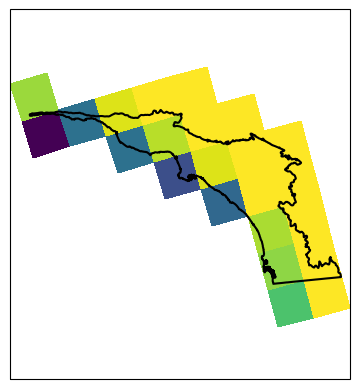

In [59]:
fig, ax = plt.subplots(subplot_kw = {"projection" : mapproj})

ax.pcolormesh(nam44_clipped.lon, nam44_clipped.lat, nam44_clipped)
baja.boundary.plot(ax = ax, color = "k")

---
# Compile variables & compute FWI

In [7]:
pr = xr.open_dataset(fpath+"era5/era5_pr_1940-2025.nc").pr
pr = pr.assign_attrs(units = "mm d-1", long_name = "Precipitation").rename(latitude = "lat", longitude = "lon")
pr = pr.assign_coords(time = pr.time.dt.floor("D"))
pr.to_netcdf("data/era5_pr.nc")

In [8]:
hurs = xr.open_dataset(fpath+"era5/era5_hurs_1940-2025.nc").hurs
hurs = hurs.assign_attrs(units = "%", long_name = "Relative humidity").rename(latitude = "lat", longitude = "lon")
hurs = hurs.assign_coords(time = hurs.time.dt.floor("D"))
hurs.to_netcdf("data/era5_hurs.nc")

In [9]:
sfcWind = xr.open_dataset(fpath+"era5/era5_sfcWind_1940-2025.nc").sfcWind
sfcWind = sfcWind.assign_attrs(units = "km h-1", long_name = "Wind speed").rename(latitude = "lat", longitude = "lon")
sfcWind = sfcWind.assign_coords(time = sfcWind.time.dt.floor("D"))
sfcWind.to_netcdf("data/era5_sfcWind.nc")

In [10]:
tas = xr.open_dataset(fpath+"era5/era5_tas_1940-2025.nc").tas
tas = tas.assign_attrs(units = "degC", long_name = "Noon temperature").rename(latitude = "lat", longitude = "lon")
tas = tas.assign_coords(time = tas.time.dt.floor("D"))
tas.to_netcdf("data/era5_tas.nc")

In [11]:
from xclim.indicators.atmos import cffwis_indices

ds = xr.merge([pr, hurs, sfcWind, tas])
# mask to land surface only
ds = ds.where(regionmask.defined_regions.natural_earth_v5_0_0.land_50.mask(ds) == 0)

In [12]:
fwi = cffwis_indices(ds = ds, overwintering = False)

/rds/general/user/cb2714/home/anaconda3/envs/wwa_xesmf/lib/python3.10/site-packages/xclim/core/cfchecks.py:44: UserWarning: Variable does not have a `cell_methods` attribute.
  _check_cell_methods(
/rds/general/user/cb2714/home/anaconda3/envs/wwa_xesmf/lib/python3.10/site-packages/xclim/core/cfchecks.py:48: UserWarning: Variable does not have a `standard_name` attribute.
  check_valid(vardata, "standard_name", data["standard_name"])


KeyError: 'units'

---
# Daily time series from gridded data

## ERA5

In [30]:
for varnm in ["pr", "BUI", "DC", "DMC", "DSR", "FFMC", "FWI", "ISI"]:
    da = xr.open_dataset(fpath+"era5_"+varnm+"_1940-2025.nc")[varnm].rio.write_crs(sf.crs)
    da_ts = da.rio.clip(sf.geometry.values, all_touched = True).mean(["latitude", "longitude"])
    
    da_ts = da_ts.rename(varnm.lower()).reset_coords(drop = True)
    da_ts.to_netcdf("data/era5_"+varnm.lower()+"_"+rnm+".nc")
    
    

In [35]:
for varnm in ["tas", "hurs", "sfcWind"]:
    da = xr.open_dataset(fpath+"era5/era5_"+varnm+"_1940-2025.nc")[varnm].rio.write_crs(sf.crs)
    da_ts = da.rio.clip(sf.geometry.values, all_touched = True).mean(["latitude", "longitude"])
    
    da_ts = da_ts.rename(varnm).reset_coords(drop = True)
    da_ts.to_netcdf("data/era5_"+varnm+"_"+rnm+".nc")

In [28]:
varnm = "FWI"
da = xr.open_dataset(fpath+"era5_"+varnm+"_1940-2025.nc")[varnm].rio.write_crs(sf.crs)
da_rm = da.rio.clip(sf.geometry.values, all_touched = True).rename("fwi")

fwi_max = da_rm.max(["latitude", "longitude"]).rename("fwimax")
fwi_max.to_netcdf("data/era5_fwimax_"+rnm+".nc")

fwi_q95 = da_rm.quantile(.95, dim = ["latitude", "longitude"]).rename("fwiq95")
fwi_q95.to_netcdf("data/era5_fwiq95_"+rnm+".nc")

In [72]:
varnm = "HDWI"
da = xr.open_dataset(fpath+"era5_noon_"+varnm+"_1940-2025.nc")[varnm].rio.write_crs(sf.crs)
da_rm = da.rio.clip(sf.geometry.values, all_touched = True).rename("hdwi")

da_mean = da_rm.mean(["latitude", "longitude"]).rename("hdwi")
da_mean.to_netcdf("data/era5_hdwi_"+rnm+".nc")

da_max = da_rm.max(["latitude", "longitude"]).rename("hdwimax")
da_max.to_netcdf("data/era5_hdwimax_"+rnm+".nc")

# Time series for analysis

## OND mean precip

In [8]:
pr = xr.open_dataset("data/era5_pr_socal-baja.nc").pr
pr_ond = pr.resample(time = "MS").sum().rolling(time = 3).mean().groupby("time.month")[12]
pr_ond.assign_coords(time = pr_ond.time.dt.year).rename("pr_ond", time = "year").to_dataframe().to_csv("ts/era5_pr-ond_"+rnm+".csv")

## OND SPI
Might be better for statistical modelling, but keep conversion parameters to map results back to precip afterwards

In [9]:
from xclim.indices.stats import fit
from scipy.stats import norm, gamma

pr_m = pr_ond.copy()
pr_cal = pr_m.sel(time = slice("1991", "2020")).copy()
pars = fit(pr_cal.dropna("time", "all"), dist = "gamma", method = "PWM")

In [10]:
spi_m = xr.apply_ufunc(lambda pr, dparams : norm.ppf(gamma.cdf(pr, *dparams)), pr_m, pars, 
                               input_core_dims = [["time"],["dparams"]], output_core_dims = [["time"]], vectorize = True).assign_coords(time = pr_m.time)

spi_m = spi_m.assign_attrs(gamma_a = pars.sel(dparams = "a").values, 
                           gamma_scale = pars.sel(dparams = "scale").values,
                           calibration = "Calibrated against 1991-2020").rename("spi_ond")

spi_m.assign_coords(time = pr_ond.time.dt.year).rename(time = "year").to_dataframe().to_csv("ts/era5_spi-ond_"+rnm+".csv")

## FWI indices

In [21]:
ts = xr.open_dataset("data/era5_fwimax_socal-baja.nc").fwimax.reset_coords(drop = True)

ts_max = ts.sel(time = ts.time.dt.month.isin([12,1])).resample(time = "AS-DEC").max()
ts_max.assign_coords(time = ts_max.time.dt.year+1).rename(time = "year").to_dataframe().to_csv("ts/era5_maxfwimax_socal-baja.csv")

In [4]:
ts = xr.open_dataset("data/era5_fwi_socal-baja.nc").fwi

for ndays in [1,2,3,5,7]:
    fwinx = ts.rolling(time = ndays).mean().sel(time = ts.time.dt.month.isin([12,1])).resample(time = "AS-DEC").max()
    fwinx.assign_coords(time = fwinx.time.dt.year+1).rename("fwi"+str(ndays)+"x", time = "year").to_dataframe().to_csv("ts/era5_fwi"+str(ndays)+"x-dj_socal-baja.csv")

In [3]:
ts = xr.open_dataset("data/era5_dsr_socal-baja.nc").dsr

for ndays in [1,2,3,5,7]:
    dsrnx = ts.rolling(time = ndays).mean().sel(time = ts.time.dt.month.isin([12,1])).resample(time = "AS-DEC").max()
    dsrnx.assign_coords(time = dsrnx.time.dt.year+1).rename("dsr"+str(ndays)+"x", time = "year").to_dataframe().to_csv("ts/era5_dsr"+str(ndays)+"x-dj_socal-baja.csv")